# Quasiperiodic Lorentz Gas

In this notebook we will see how the apply the code contained in the file "Magnetorresistencia_En_Cuasicristales.jl" to study the diffusion of an electron in a 2D plate doped with antiquantum dots in the presence of an external magnetic field. To do that we use a generalization of the "Cut-and-Project" method.

First, let's load the file that contain all the code that we will use in this notebook.

In [1]:
include("Magnetorresistencia_En_Cuasicristales.jl");

To visualize our results we will use the "Plots" package, so let's load it.

In [2]:
using Plots

### Configuration of the system

Let's generate the parameters that will define our system:

In [3]:
Box_Size_Length = 1.0; #The length of one side of the cubic box centered at the origin that will contain the cylinder.
Cylinder_Axis = [π*0.008, sqrt(2)*0.008, 1]; #Vector that point into the direction of the cylinder axis.
Cylinder_Axis = Cylinder_Axis/norm(Cylinder_Axis); #Let's normalize the vector Cylinder_Axis.
Trajectory_Radius = 0.506; #Radius of the circular trajectory that follows our particle.

Z_to_Cyl_Matrix = mat_Rot(Cylinder_Axis); #Generate the matrix that rotates the vector (0,0,1) to the vector "Cylinder_Axis"
Cyl_to_Z_Matrix = (Z_to_Cyl_Matrix)^-1; #Generate the matrix that rotates the vector "Cylinder_Axis" to the vector (0,0,1)
Cylinder_Radius = 0.28; #Define the radius of the cylinder inside the unitary cube.

#Now let's calculates the length of the cylinder. This length will be determinated as the maximum distance between the
#projections to the "infinite" cylinder of the vertices of the cube.
Cylinder_Length = longitud_Cilindro(Box_Size_Length, Cyl_to_Z_Matrix);

### Algorithm for the Mean Square Displacement of a particle

In [4]:
Trajectories_Number = 10; #Number of trajectories (each one related to a different particle) that we will consider

Initial_Position_X_Array = Array[]; #An array that will contain the X coordinates of the different initial positions in the 2D projected plane
Initial_Position_Y_Array = Array[]; #An array that will contain the Y coordinates of the different initial positions in the 2D projected plane
Final_X_Coordinates = Array[]; #An array that will contain the X coordinates of the positions of the particles at the end of each Flight in each trajectory
Final_Y_Coordinates = Array[]; #An array that will contain the Y coordinates of the positions of the particles at the end of each Flight in each trajectory

Total_Obstacles_Centers = Array[]; #An array that will contain all the obstacles centers of all the trajectories

Fly_Time = 10; #Determine the length of each of the Flights that make up the trajectory of the particle
Number_Flights = 1000; #Determine the number of Flights that the particle will realize

for i in 1:Trajectories_Number
    @show i #We show to the user the actual step of the iterations
    
    #GENERATE THE INITIAL CONDITIONS OF ONE PARTICLE (TRAJECTORY)
    θ = π*rand() - π/2; #Let's define one angle between -π/2 and π/2
    θ2 = π*rand(); #Let's define one angle between 0 and π
    Height = rand()-0.5; #Height of the initial position of the particle
    Box_Coordinates = zeros(Float64, 3); #An array with the coordinates of the box that contain the particle after a certain number of periodic bound conditions applied to it
    Collision_Position = [Cylinder_Radius*cos(θ2), Cylinder_Radius*sin(θ2), 0.0]; #Position projected in the plane XY after the cylinder is vertical associated with the point where the particle collide with the cylinder
    Normalized_Collision_Position = Collision_Position/norm(Collision_Position); #Let's normalize the vector Collision_Position
    Velocity = [cos(θ),sin(θ),0.0]; #Velocity vector in the plane XY with arbitrary direction between the quadrants [IV,I]
    Orthogonal_Velocity = (Normalized_Collision_Position⋅Velocity)*[Normalized_Collision_Position[1], Normalized_Collision_Position[2], 0.0]; #Orthogonal component of the velocity of the particle after the collision
    Velocity_After_Collision = Velocity - 2*Orthogonal_Velocity; #Velocity of the particle after the collision
    Velocity_After_Collision = Z_to_Cyl_Matrix*Velocity_After_Collision; #Get the velocity after the collision in the coordinates where the cylinder is not vertical
    
    Initial_Velocity = Velocity_After_Collision; #Let's set the initial velocity of our particle as the velocity after one collision in the coordinates where the cylinder is not vertical
    Initial_Velocity /= norm(Initial_Velocity); #Let's normalize the initial velocity of our particle
    Initial_Position = Z_to_Cyl_Matrix*(Collision_Position + [0.0, 0.0, Height]) - Initial_Velocity * 0.000000001; #Let's set the initial position of our particle as the position an instant after the collision
    Initial_Position_Cyl_Vertical = Cyl_to_Z_Matrix*Initial_Position; #Initial position of our particle in the coordinates where the cylinder is vertical
    
    push!(Initial_Position_X_Array, [Initial_Position_Cyl_Vertical[1]]); #Let's push the X coordinate of the initial position in the space where the cylinder is vertical into the corresponding array
    push!(Initial_Position_Y_Array, [Initial_Position_Cyl_Vertical[2]]); #Let's push the Y coordinate of the initial position in the space where the cylinder is vertical into the corresponding array
    
    After_Flight_X_Coordinate = []; #An array that will have the X coordinate in the 2D projected plane of the particle after each Flights
    After_Flight_Y_Coordinate = []; #An array that will have the Y coordinate in the 2D projected plane of the particle after each Flights
    Trajectory_Obstacle_Centers = Array[]; #An array with all the obstacle centers with which the particle collided in one trajectory
    
    #ITERATES OVER ALL THE FLIGHTS FOR ONE TRAJECTORY
    for k in 1:Number_Flights
        Flight_Obstacles_Centers = []; #Define an array that will contain the centers in the 2D projected plane of the obstacle with which the particle collide with in one Flight
        
        #Let's calculate, for each iteration "k"...
        #Initial_Position: The final position of the particle after a given Fly_Time parameter for the particle.
        #Initial_Velocity: The final velocity of the particle after a fiven Fly_Time parameter for the particle.
        #Box_Coordinates_Partial: The coordinates of the center of the box that contains, at the end, the particle.
        #θ_Position_After_Collision_Array: An array with the angle beetween x axis and the collision position of the
        #                                  particle.
        #θ_Velocity_After_Collision_Array: An array with the angle beetween x axis and the velocity vector after the
        #                                  collision of the particle.
        #Height_Array: An array with the heights of the particles relative to the center of the vertical cylinder
        #Flight_Obstacles_Centers: An array with the centers of the obstacles in the 2D projected plane with which the particle collide in this Flight
        Initial_Position, Initial_Velocity, Box_Coordinates_Partial, θ_Position_After_Collision_Array, θ_Velocity_After_Collision_Array, Height_Array, Flight_Obstacles_Centers = lorentz_Cuasi_Magnetico2(Initial_Position, Initial_Velocity, Cylinder_Axis, Box_Size_Length, Trajectory_Radius, Cylinder_Radius, Fly_Time, Flight_Obstacles_Centers, Box_Coordinates, false);
        
        Box_Coordinates += Box_Coordinates_Partial; #Update the Box_Coordinates that will have the box's coordinates that contain the particle at the end
        Initial_Position_Cyl_Vertical = Cyl_to_Z_Matrix*(Initial_Position + Box_Coordinates); #Position of the particle after the kth iteration in the 2D projected plane
        
        #Let's save the information of the X and Y coordinates of the particle after a Flight
        push!(After_Flight_X_Coordinate, Initial_Position_Cyl_Vertical[1]);
        push!(After_Flight_Y_Coordinate, Initial_Position_Cyl_Vertical[2]);
        
        #Let's save the centers of the obstacles with which the particle collides
        push!(Trajectory_Obstacle_Centers, Flight_Obstacles_Centers)
    end
    
    #Let's save the obstacles centers of the trajectory in the array of all the obstacles centers
    push!(Total_Obstacles_Centers, Trajectory_Obstacle_Centers);
    
    #Let's save the X and Y coordinates of the particle at the end of the different Flights in this trajectory
    push!(Final_X_Coordinates, After_Flight_X_Coordinate);
    push!(Final_Y_Coordinates, After_Flight_Y_Coordinate);
end

i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10


### Calculations to determine the Mean Square Displacement

In [5]:
#Function that calculates the MSD of a particle with one of his trajectories
function MSD(Final_X_Coordinates,Final_Y_Coordinates,Fly_Time)
    Trajectories_Number = length(Final_X_Coordinates); #Number of trajectories simulated
    Flight_Number = length(Final_X_Coordinates[1]); #Number of Flights that conform one trajectory
    MeanSD = zeros(Flight_Number); #An array that will contain the MSD of the particles at each Flight
    Accumulated_Fly_Time = zeros(Flight_Number); #The accumulated Fly Time of the particles at the end of each Flight
    
    #Let's obtain the accumulated Fly Time of the particles
    for j in 1:Flight_Number
        Accumulated_Fly_Time[j] = j*Fly_Time
    end
    
    #Let's obtain the sum of the MSD at the end of each Flight
    for i in 1:Trajectories_Number
        for j in 1:Flight_Number
            MeanSD[j] += (Final_X_Coordinates[i][j])^2 + (Final_Y_Coordinates[i][j])^2
        end
    end
    
    #The average of the MSD at the end of each Flight over the number of trajectories
    MeanSD = MeanSD./Trajectories_Number;
    
    return Accumulated_Fly_Time, MeanSD
end

MSD (generic function with 1 method)

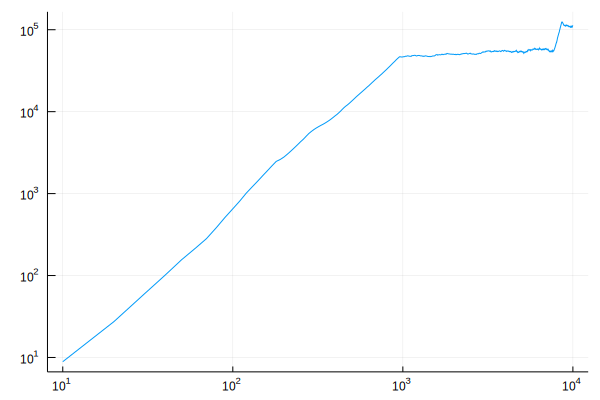

In [6]:
Accumulated_Fly_Time, MeanSD = MSD(Final_X_Coordinates,Final_Y_Coordinates,Fly_Time)
plot(Accumulated_Fly_Time, MeanSD, key = false)
plot!(xscale = :log10, yscale = :log10)

In [7]:
#I DON'T UNDERSTAND WHY YOU DID THIS LAST OPERATION.
MeanSD = MeanSD./11

1000-element Array{Float64,1}:
     0.8077374168909853
     2.4928183972351956
     5.362498448861505 
     9.19841419799211  
    14.183242931667673 
    19.450328644331798 
    25.65886792089822  
    34.89972883522043  
    46.598757380314574 
    59.30436994193538  
    73.95063046160486  
    92.12351544437911  
   109.84041267397834  
     ⋮                 
  9801.09057439617     
  9805.36003367613     
  9794.393617339758    
  9884.126268115519    
  9947.405790299004    
 10013.772902381515    
 10061.600473282379    
 10135.38393407943     
 10184.58251204461     
 10207.603233209966    
 10253.798682363256    
 10283.975370602122    